In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils_temp import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [4]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 0.5
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [5]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015.csv", index_col=['regionbase'],header='infer')
    #df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
    #df = pd.read_excel("../../raw_data/baselinecarbon_direct_2018.xlsx", index_col = 0)
#df['CeHH'] = df['CeHH_old']
#df['Cec'] = 0
#df['CeFF'] = df['CeFF_old']
#df['Cecstar'] = 0
#df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
#df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])
df['jxbar']=df['Cex']/(df['Cex'] + df['Ceystar'])
df['jmbar']=df['Cey']/(df['Cey'] + df['Cem'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[(df['region_scenario'] == 3)] 
#df = df[df['region_scenario'] != 4]
df

region_scenario       Qe   Qestar   Qeworld  Ced  Cedstar  \
regionbase                                                                  
OECD37 as Home                3  8.62549  23.6505  32.27599  0.0      0.0   

                     Cey      Cem      Cex   Ceystar        Ce    Cestar  \
regionbase                                                                 
OECD37 as Home  11.29367  2.48754  0.91057  17.58421  13.78121  18.49478   

                      Ge    Gestar   Ceworld   Geworld     jxbar     jmbar  
regionbase                                                                  
OECD37 as Home  12.20424  20.07175  32.27599  32.27599  0.049234  0.819498

In [6]:
#tax_scenario= pd.DataFrame({'tax_sce': ['global','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','PC_hybrid'], 'Base':[0,1]},index=[1,2])
tax_scenario= pd.DataFrame({'tax_sce': ['puretp', 'EP_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp'], 'Base':[0,1,1,1]},index=[1,2,3,4])

In [7]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,5,0.1)
    #varphilist = np.arange (0,1,0.2)
    varphilist = [0,0.5, 1,2]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [8]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [ ]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

1.2231199962180397 0.5194434570089507 -3.71065999621804 -18.1036534570089
1.1094058922612604 0.4711505278992749 -3.36567800110480 -16.4205473532961
1.2229314854520197 0.5192434148839595 -3.71108297475717 -18.1037130615940
1.2231199962180397 0.5194434570089507 -3.71065999621804 -18.1036534570089
1.3551110258630539 0.5754050563871107 -4.11186352458426 -20.0594961632187
1.164154041097929 0.49438279239269317 -3.53192507146631 -17.2313272104215
1.2865465515120464 0.5463151669362881 -3.90361805911938 -19.0439805669611
1.1930605154324343 0.506648671536194 -3.61970620788981 -17.6594233088145
1.254199465483385 0.5325905829830051 -3.80537834538737 -18.5649003526935
1.2079191743908744 0.5129535047635955 -3.66482908528881 -17.8794788336137
1.2384814925602934 0.5259214286685094 -3.75764337866557 -18.3321112445929
1.2154528130878832 0.5161501461388929 -3.68770758790419 -17.9910522575158
1.2307330777619394 0.5226337291970836 -3.73411201326961 -18.2173552020497
1.2268861103199893 0.5210014281837658 -3

In [30]:
output_list=[]
for i in range(0,len(tax_scenario)):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

tax_sce      regionbase  varphi        pe        tb      prop        te  \
0  PC_hybrid  OECD37 as Home     0.0  1.000000  0.000000  0.500000  0.000000   
1  PC_hybrid  OECD37 as Home     0.5  0.935564  0.255322  0.421686  0.255322   
2  PC_hybrid  OECD37 as Home     1.0  0.892956  0.487170  0.470300  0.487170   
3  PC_hybrid  OECD37 as Home     2.0  0.840102  0.914804  0.546349  0.914804   
0  EC_hybrid  OECD37 as Home     0.0  1.000000  0.000000  0.500000  0.000000   
1  EC_hybrid  OECD37 as Home     0.5  0.983180  0.191989  0.000000  0.500000   
2  EC_hybrid  OECD37 as Home     1.0  0.987412  0.385503  0.000000  1.000000   
3  EC_hybrid  OECD37 as Home     2.0  1.072308  0.830389  0.000000  2.000000   
0     puretp  OECD37 as Home     0.0  1.000000  0.000000  0.500000  0.000000   
1     puretp  OECD37 as Home     0.5  0.937885  0.318134  0.294949  0.318134   
2     puretp  OECD37 as Home     1.0  0.908755  0.557766  0.081295  0.557766   
3     puretp  OECD37 as Home     2.0  0.882317  0.904141  0.056613  0.904141   
0  EP_hybrid  OECD37 as Home     0.0  1.000000  0.000000  0.000000  0.000000   
1  EP_hybrid  OECD37 as Home     0.5  1.000204  0.147612  0.000000  0.474375   
2  EP_hybrid  OECD37 as Home     1.0  1.018906  0.290749  0.000000  0.940360   
3  EP_hybrid  OECD37 as Home     2.0  1.127001  0.601246  0.000000  1.728248   

   jxbar_prime  jmbar_prime  j0_prime  ...               leak  \
0     0.049234     0.819498  0.049234  ...  0.124943572845991   
1     0.045277     0.819498  0.042882  ...  0.131310213740582   
2     0.042574     0.819498  0.038349  ...  0.137269275268844   
3     0.039107     0.819498  0.032212  ...  0.148407001456884   
0     0.049234     0.819498  0.049234  ...                0.0   
1     0.049234     0.819498  0.044459  ...                0.0   
2     0.049234     0.819498  0.040760  ...                0.0   
3     0.049234     0.819498  0.035408  ...                0.0   
0     0.049234     0.819498  0.049234  ...  0.124943572845991   
1     0.041649     0.792112  0.041649  ...  0.179129235099258   
2     0.037405     0.773083  0.037405  ...  0.226254149756263   
3     0.032801     0.748322  0.032801  ...  0.301347359701924   
0     0.049234     0.819498  0.049234  ...  0.124943572845991   
1     0.045508     0.806956  0.045508  ...  0.147920797209221   
2     0.042643     0.796138  0.042643  ...  0.170210871905059   
3     0.038523     0.778409  0.038523  ...  0.212202462337039   

            leakstar       welfare  welfare_noexternality  Qe1_prime  \
0  0.363243754429718 -0.000000e+00           0.000000e+00   8.625490   
1  0.421685813655463  2.697431e-01          -3.055947e-01   8.342967   
2  0.470299971395121  9.747578e-01          -9.586947e-01   8.150774   
3  0.546348948392677  3.270695e+00          -2.591129e+00   7.905870   
0                0.0 -0.000000e+00           0.000000e+00   8.625490   
1                0.0  4.749264e-01          -4.708126e-01   7.087449   
2                0.0  1.896967e+00          -1.920742e+00   5.267310   
3                0.0  8.075460e+00          -8.872307e+00   0.000000   
0  0.363243754429718 -0.000000e+00           0.000000e+00   8.625490   
1  0.488921190680141  8.309318e-02          -4.711870e-01   8.353308   
2  0.590814931739077  4.321389e-01          -1.208935e+00   8.222561   
3  0.743515859337820  1.782035e+00          -2.481566e+00   8.102074   
0  0.363243754429717  9.367304e-07           9.367304e-07   8.625490   
1  0.417890547915757  4.202759e-01          -4.203752e-01   7.078380   
2  0.468952483800920  1.691266e+00          -1.749610e+00   5.241676   
3  0.561010992528227  7.345696e+00          -8.259344e+00   0.000000   

   Qe1star_prime  Qe2_prime  Qe2star_prime  region_scenario  conv  
0      23.650500        0.0            0.0              3.0   1.0  
1      22.875842        0.0            0.0              3.0   1.0  
2      22.348862        0.0            0.0              3.0   1.0  
3      21.677352        0.0            0.

In [25]:
Outcomes[['pe','tb', 'Ced_prime', 'Cedstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vg_prime']]

pe        tb  Ced_prime  Cedstar_prime  Cey_prime  Cex_prime  \
0  1.000000  0.000000        0.0            0.0  11.293670   0.910570   
1  0.935564  0.255322        0.0            0.0   9.483417   0.773061   
2  0.892956  0.487170        0.0            0.0   8.183072   0.684095   
3  0.840102  0.914804        0.0            0.0   6.435485   0.576271   
0  1.000000  0.000000        0.0            0.0  11.293670   0.910570   
1  0.937885  0.318134        0.0            0.0   8.691164   0.613282   
2  0.908755  0.557766        0.0            0.0   7.264828   0.471726   
3  0.882317  0.904141        0.0            0.0   5.772757   0.339580   
0  1.000000  0.000000        0.0            0.0  11.293670   0.910570   
1  1.000204  0.147612        0.0            0.0   9.688687   0.733279   
2  1.018906  0.290749        0.0            0.0   8.377584   0.602203   
3  1.127001  0.601246        0.0            0.0   6.207108   0.412253   

   Cem_prime  Ceystar_prime    Vg_prime  
0   2.487540      17.584210   91.874733  
1   2.088814      18.873516   91.874733  
2   1.802401      19.830065   91.874733  
3   1.417478      21.153990   91.874733  
0   2.487540      17.584210   91.874733  
1   3.054692      18.898365   98.353403  
2   3.441177      19.590527  104.670553  
3   3.931036      20.274035  115.569465  
0   2.487540      17.584210   91.874733  
1   2.659830      17.649502   94.492221  
2   2.757339      17.377567   97.219354  
3   2.709660      15.778425  102.735889

In [24]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb','te','varphi', 'Qe_prime', 'Qeworld_prime','delta_Vg','delta_Vgstar','delta_Le','delta_Lestar','delta_UCed', 'delta_UCedstar','welfare','welfare_noexternality']]

pe        tb        te  varphi  Qe_prime  Qeworld_prime  \
0  1.000000  0.000000  0.000000     0.0  8.625490      32.275990   
1  0.935564  0.255322  0.255322     0.5  8.342967      31.218810   
2  0.892956  0.487170  0.487170     1.0  8.150774      30.499636   
3  0.840102  0.914804  0.914804     2.0  7.905870      29.583223   
0  1.000000  0.000000  0.000000     0.0  8.625490      32.275990   
1  0.937885  0.318134  0.318134     0.5  8.353308      31.257503   
2  0.908755  0.557766  0.557766     1.0  8.222561      30.768258   
3  0.882317  0.904141  0.904141     2.0  8.102074      30.317404   
0  1.000000  0.000000  0.000000     0.0  8.625490      32.275990   
1  1.000204  0.147612  0.474375     0.5  7.078380      30.731298   
2  1.018906  0.290749  0.940360     1.0  5.241676      29.114694   
3  1.127001  0.601246  1.728248     2.0  0.000000      25.107446   

       delta_Vg  delta_Vgstar      delta_Le  delta_Lestar  delta_UCed  \
0 -0.000000e+00 -0.000000e+00  0.000000e+00  0.000000e+00        -0.0   
1 -2.407546e+00  1.103851e+00 -2.733698e-01 -7.495611e-01        -0.0   
2 -4.439958e+00  1.878776e+00 -4.490686e-01 -1.231315e+00        -0.0   
3 -7.750762e+00  2.895811e+00 -6.612519e-01 -1.813107e+00        -0.0   
0 -0.000000e+00 -0.000000e+00  0.000000e+00  0.000000e+00        -0.0   
1 -2.360702e+00  9.411140e-01 -2.636836e-01 -7.230024e-01        -0.0   
2 -3.937547e+00  1.388444e+00 -3.843997e-01 -1.053997e+00        -0.0   
3 -5.909459e+00  1.787389e+00 -4.922962e-01 -1.349842e+00        -0.0   
0  2.449781e-07  3.287677e-07 -7.666439e-08 -2.102085e-07         0.0   
1 -1.545678e+00 -1.243264e-01 -1.286204e+00  2.418121e-03        -0.0   
2 -3.053425e+00 -5.593287e-01 -2.229923e+00  2.246181e-01        -0.0   
3 -6.358316e+00 -2.556556e+00 -2.875163e+00  1.548541e+00        -0.0   

   delta_UCedstar       welfare  welfare_noexternality  
0            -0.0 -0.000000e+00           0.000000e+00  
1             0.0  2.697431e-01          -3.055947e-01  
2             0.0  9.747578e-01          -9.586947e-01  
3             0.0  3.270695e+00          -2.591129e+00  
0            -0.0 -0.000000e+00           0.000000e+00  
1             0.0  8.309318e-02          -4.711870e-01  
2             0.0  4.321389e-01          -1.208935e+00  
3             0.0  1.782035e+00          -2.481566e+00  
0             0.0  9.367304e-07           9.367304e-07  
1            -0.0  4.202759e-01          -4.203752e-01  
2            -0.0  1.691266e+00          -1.749610e+00  
3            -0.0  7.345696e+00          -8.259344e+00

In [12]:
Outcomes[['pe','tb','Lg_prime', 'Lgstar_prime']]

pe        tb   Lg_prime  Lgstar_prime
0   1.000000  0.000000  54.738527    102.991950
1   0.993667  0.039978  54.740831    102.989997
2   0.988370  0.079571  54.747517    102.984353
3   0.984048  0.118885  54.758271    102.975314
4   0.980651  0.158020  54.772820    102.963138
..       ...       ...        ...           ...
25  1.043300  1.028525  53.735238    103.995238
26  1.039442  1.066082  53.713399    104.017078
27  1.035726  1.103491  53.692315    104.038161
28  1.032145  1.140761  53.671949    104.058528
29  1.028692  1.177898  53.652263    104.078214

[240 rows x 4 columns]

In [21]:
Outcomes.to_csv('../../output/direct_consumption_constrained.csv', header=True)

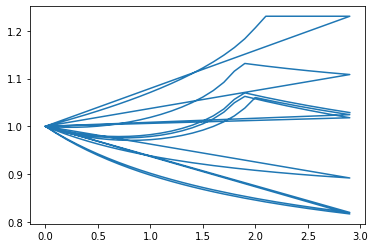

In [14]:
import matplotlib.pyplot as plt
plt.plot(Outcomes['varphi'], Outcomes['pe'])

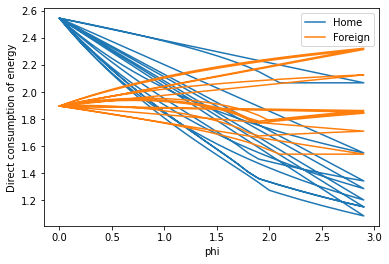

In [15]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Direct consumption of energy")
plt.legend()
#plt.savefig('phi_cec.pdf', format='PDF')

In [16]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

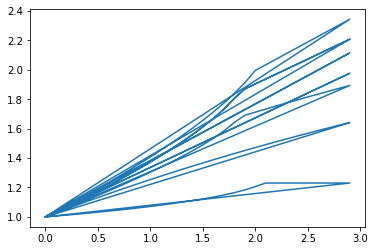

In [17]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

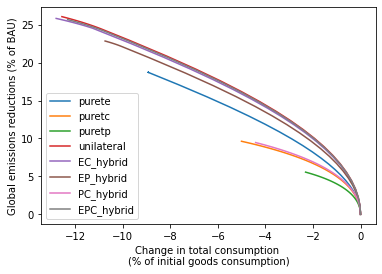

In [18]:
df = pd.read_csv('../../output_sig0/ces0.csv')
df = df[(df['region_scenario'] == 3) & (df['tax_sce'] == 'PC_hybrid') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100

df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'purete')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretc']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretc')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretp']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretp')

df_plot = Outcomes[Outcomes['tax_sce'] == 'Unilateral']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'unilateral')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EP_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EP_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'PC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'PC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EPC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EPC_hybrid')

#df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
#plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

#plt.savefig('wf_chg.pdf', format = 'PDF')

C:\Users\Alex\AppData\Local\Temp/ipykernel_13428/958572098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Ceworld_prime'] = df_plot['Cec_prime'] + df_plot['Cecstar_prime'] + df_plot['Cey_prime'] + df_plot['Cem_prime'] + df_plot['Cex_prime'] + df_plot['Ceystar_prime']


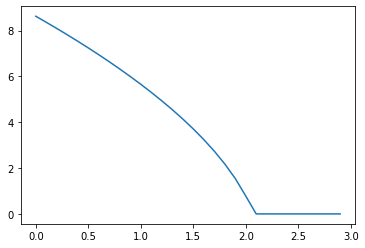

In [19]:
df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
#plt.plot(df_plot['varphi'], df_plot['Qeworld_prime'], label = 'purete')
df_plot['Ceworld_prime'] = df_plot['Cec_prime'] + df_plot['Cecstar_prime'] + df_plot['Cey_prime'] + df_plot['Cem_prime'] + df_plot['Cex_prime'] + df_plot['Ceystar_prime']
plt.plot(df_plot['varphi'], df_plot['Qe_prime'], label = 'purete')

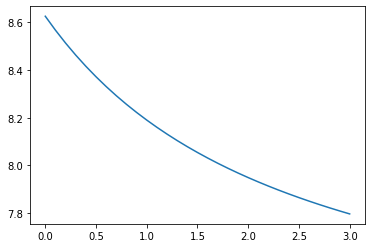

In [20]:
plt.plot(df['varphi'], df['Qe_prime'], label = 'purete')

In [21]:
df[['pe','tb', 'varphi','Cey_prime','Cex_prime','Vg_prime', 'Vgstar_prime', 'Vgx_prime', 'Vgm_prime']]

pe        tb  varphi  Cey_prime  Cex_prime   Vg_prime  \
3800  1.000000  0.000000     0.0  11.293670   0.910570  91.874733   
3801  0.986510  0.046870     0.1  10.928872   0.881510  91.874733   
3802  0.974072  0.092767     0.2  10.586111   0.854840  91.874733   
3803  0.962574  0.137787     0.3  10.263600   0.830295  91.874733   
3804  0.951920  0.182015     0.4   9.959712   0.807646  91.874733   
3805  0.942024  0.225526     0.5   9.672967   0.786693  91.874733   
3806  0.932810  0.268386     0.6   9.402023   0.767261  91.874733   
3807  0.924213  0.310653     0.7   9.145662   0.749198  91.874733   
3808  0.916176  0.352380     0.8   8.902777   0.732369  91.874733   
3809  0.908646  0.393613     0.9   8.672368   0.716658  91.874733   
3810  0.901578  0.434394     1.0   8.453520   0.701960  91.874733   
3811  0.894932  0.474760     1.1   8.245404   0.688183  91.874733   
3812  0.888673  0.514744     1.2   8.047266   0.675247  91.874733   
3813  0.882767  0.554376     1.3   7.858416   0.663078  91.874733   
3814  0.877186  0.593684     1.4   7.678224   0.651612  91.874733   
3815  0.871905  0.632690     1.5   7.506118   0.640791  91.874733   
3816  0.866901  0.671418     1.6   7.341568   0.630564  91.874733   
3817  0.862151  0.709887     1.7   7.184094   0.620884  91.874733   
3818  0.857639  0.748115     1.8   7.033252   0.611708  91.874733   
3819  0.853345  0.786119     1.9   6.888633   0.603001  91.874733   
3820  0.849256  0.823914     2.0   6.749863   0.594726  91.874733   
3821  0.845357  0.861513     2.1   6.616596   0.586854  91.874733   
3822  0.841635  0.898929     2.2   6.488510   0.579355  91.874733   
3823  0.838079  0.936174     2.3   6.365312   0.572205  91.874733   
3824  0.834677  0.973258     2.4   6.246726   0.565380  91.874733   
3825  0.831419  1.010190     2.5   6.132498   0.558859  91.874733   
3826  0.828298  1.046981     2.6   6.022394   0.552622  91.874733   
3827  0.825304  1.083637     2.7   5.916194   0.546651  91.874733   
3828  0.822431  1.120168     2.8   5.813693   0.540929  91.874733   
3829  0.819670  1.156579     2.9   5.714702   0.535443  91.874733   
3830  0.817015  1.192877     3.0   5.619043   0.530176  91.874733   

      Vgstar_prime  Vgx_prime  Vgm_prime  
3800    123.298533   6.070467    16.5836  
3801    123.298533   5.969814    16.5836  
3802    123.298533   5.876343    16.5836  
3803    123.298533   5.789350    16.5836  
3804    123.298533   5.708214    16.5836  
3805    123.298533   5.632383    16.5836  
3806    123.298533   5.561372    16.5836  
3807    123.298533   5.494746    16.5836  
3808    123.298533   5.432121    16.5836  
3809    123.298533   5.373155    16.5836  
3810    123.298533   5.317540    16.5836  
3811    123.298533   5.265003    16.5836  
3812    123.298533   5.215298    16.5836  
3813    123.298533   5.168204    16.5836  
3814    123.298533   5.123523    16.5836  
3815    123.298533   5.081074    16.5836  
3816    123.298533   5.040694    16.5836  
3817    123.298533   5.002238    16.5836  
3818    123.298533   4.965571    16.5836  
3819    123.298533   4.930571    16.5836  
3820    123.298533   4.897126    16.5836  
3821    123.298533   4.865136    16.5836  
3822    123.298533   4.834507    16.5836  
3823    123.298533   4.805155    16.5836  
3824    123.298533   4.777000    16.5836  
3825    123.298533   4.749971    16.5836  
3826    123.298533   4.724001    16.5836  
3827    123.298533   4.699030    16.5836  
3828    123.298533   4.675000    16.5836  
3829    123.298533   4.651859    16.5836  
3830    123.298533   4.629558    16.5836